## Manage imports

In [2]:
import scipy
import os
import mne
import matplotlib
import matplotlib.pyplot as plt
import numpy as np
from einops import rearrange
from scipy import io

## Read local data

In [3]:
# Constants used to define data paths
ROOT_DIR = './'
RAW_DIR = 'data/matlabPREPROCESSED'
PROCESSED_DIR = 'data/graphProcessedData'

In [4]:
raw_file_names = os.listdir(RAW_DIR)
raw_file_names.sort()
all_subjects = [scipy.io.loadmat(f'{RAW_DIR}/{name}') for name in raw_file_names]

In [5]:
all_data = [subject['data'] for subject in all_subjects]
all_labels = [subject['labels'] for subject in all_subjects]
labels = np.stack(all_labels)
data = np.stack(all_data)
# Keep just EEG signals and remove first 3 seconds
data = data[:,:,:32,128*3:]

In [6]:
data.shape

(32, 40, 32, 7680)

In [7]:
first_participant_data = data[0]
first_participant_data.shape

(40, 32, 7680)

In [8]:
first_participant_data[0].shape

(32, 7680)

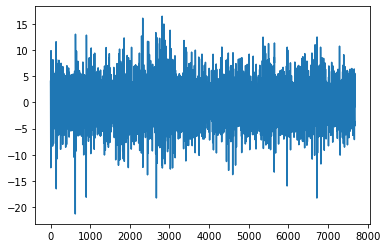

In [9]:
import matplotlib.pyplot as plt
plt.plot(first_participant_data[0][0])

In [10]:
def create_data_for_participant(participant_data, look_back = 1, window_size=128, overlap_sequences=True, n_videos=40):
    """
    For a certain participant, create input and target features
    :param participant_data: Original participant_data. Shape (40, 32, 7680)
    :param look_back: Number of windows included as input features
    :param window_size: Number of data points per window
    :param overlap_sequences: Wether to add 1 or window_size to get the next sequence.
    :return: 
        inputs: Input features with shape (N, look_back, 32, window_size)
        targets: Target with shape (N, 32, window_size)
    """
    inputs = []
    targets = []
    for video in participant_data[:n_videos]:
        idx = 0
        while idx + window_size * (look_back + 1) <= video.shape[1]:
#             print(idx, idx+window_size*look_back)
#             print(idx+window_size*look_back,idx+window_size*(look_back+1))
            inpt = video[:,idx:idx+window_size*look_back]
            inpt = rearrange(inpt,'a (b c) -> b a c',c=window_size)
            tget = video[:,idx+window_size*look_back:idx+window_size*(look_back+1)]
            inputs.append(inpt)
            targets.append(tget)
            if overlap_sequences:
                idx += 10
            else:
                idx += window_size
#             print(idx)
#             print(tget.shape)
#         print(len(inputs))
    
    return inputs,targets

look_back = 10
window_size = 128
inputs, targets = create_data_for_participant(first_participant_data,look_back,window_size,True)

In [11]:
len(inputs),len(targets)

(25120, 25120)

In [12]:
inputs[0].shape, targets[0].shape

((10, 32, 128), (32, 128))

In [17]:
targets[0]

array([[ 4.34449797,  3.12143258, -1.99934033, ..., -6.6957948 ,
        -6.31902842, -3.33689666],
       [ 3.65577633,  4.18299247, -0.07301596, ..., -2.96785212,
        -3.93465645, -0.15646287],
       [ 2.03966913,  1.76355649,  0.09397287, ..., -3.41369664,
        -4.38745875, -0.71169342],
       ...,
       [ 4.70944462,  3.91674961,  2.76729718, ...,  0.69950872,
         0.64455754, -1.39503669],
       [-3.04320454, -2.87813307,  0.99223196, ...,  0.86336261,
         3.22549374,  1.51269125],
       [-2.06397904, -0.02035828,  2.45051504, ..., -1.59205962,
         0.97492084, -0.47998268]])

## Define model

In [12]:
import torch
import torch.nn as nn
import torch.nn.functional as F

In [13]:
class LSTMPredictor(torch.nn.Module):
    def __init__(self, in_channels, lstm_cells,look_back):
        super(LSTMPredictor, self).__init__()
        self.lstm = nn.LSTM(in_channels, in_channels*2, lstm_cells)
        self.lin = nn.Linear(in_channels*2*look_back,in_channels)
        

    def forward(self, x):
        out, _ = self.lstm(x)
        
        x = rearrange(out,'a b c -> b (a c)')
        x = F.dropout(x, p=0.25, training=self.training)
        x = self.lin(x)
        return x

## Define dataset

In [14]:
from torch.utils.data import Dataset, DataLoader
class DEAPPrediction(Dataset):

    def __init__(self, inputs, targets, transform=None):
        self.inputs = inputs
        self.targets = targets
        self.transform = transform

    def __len__(self):
        return len(self.inputs)

    def __getitem__(self, idx):
        if torch.is_tensor(idx):
            idx = idx.tolist()

        sample = {'input': self.inputs[idx], 'target': self.targets[idx]}

        if self.transform:
            sample = self.transform(sample)

        return sample

In [15]:
inputs = torch.FloatTensor(inputs)
targets = torch.FloatTensor(targets)

train_inputs = inputs[:int(len(inputs)*0.8)]
train_targets = targets[:int(len(inputs)*0.8)]
test_inputs = inputs[int(len(inputs)*0.8):]
test_targets = targets[:int(len(inputs)*0.8)]

train_dataset = DEAPPrediction(train_inputs,train_targets)
test_dataset = DEAPPrediction(test_inputs,test_targets)

train_loader = DataLoader(train_dataset, batch_size=32,shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=32)

In [16]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device

device(type='cuda')

In [ ]:
model = LSTMPredictor(window_size,2,look_back)     
pytorch_total_params = sum(p.numel() for p in model.parameters())
print(f'Model parameter count: {pytorch_total_params}')

# optimizer = torch.optim.Adam(model.parameters(), lr=0.01)
optimizer = torch.optim.Adadelta(model.parameters(), lr=1, rho=0.9, eps=1e-06, weight_decay=0.01)

criterion = nn.MSELoss()
model = model.to(device)

def train():
    model.train()
    losses = []
    for batch in train_loader:
        optimizer.zero_grad()
        inpt = batch['input'].to(device)
        tget = batch['target'].to(device)
        
        inpt = rearrange(inpt, 'a b c d -> b (a c) d')
        tget = rearrange(tget, 'a b c -> (a b) c')
        
        out = model(inpt)
        loss = criterion(out,tget)
        loss.backward()
        losses.append(loss.item())
        optimizer.step()
    return np.array(losses).mean()


def test():
    model.eval()
    losses = []
    for batch in test_loader:
        inpt = batch['input'].to(device)
        tget = batch['target'].to(device)
        
        inpt = rearrange(inpt, 'a b c d -> b (a c) d')
        tget = rearrange(tget, 'a b c -> (a b) c')
        
        out = model(inpt)
        loss = criterion(out,tget)
        losses.append(loss.item())
    return np.array(losses).mean()

best_val_loss = np.inf
esp = 0
MAX_ESP = 20
for epoch in range(1, 2000):
    train_loss = train()
    test_loss = test()
#     if test_loss < best_val_loss:
#         best_val_loss = test_loss
#         esp = 0
#     else:
#         esp += 1
#         if esp >= MAX_ESP:
#             break
    print(f'Epoch {epoch} ; Train loss: {train_loss} ; Test loss: {test_loss}')

Model parameter count: 1249408
Epoch 1 ; Train loss: 18.458124379443515 ; Test loss: 17.624909789698897
Epoch 2 ; Train loss: 18.06024005306754 ; Test loss: 17.865214353913714
Epoch 3 ; Train loss: 17.830401031834306 ; Test loss: 17.9649560831155
Epoch 4 ; Train loss: 17.71068220837101 ; Test loss: 18.177021099503634
Epoch 5 ; Train loss: 17.6795483819998 ; Test loss: 18.139592808522995
Epoch 6 ; Train loss: 17.64960427800561 ; Test loss: 17.99579418692619
Epoch 7 ; Train loss: 17.6362078903587 ; Test loss: 18.18427670229772
Epoch 8 ; Train loss: 17.631008177046564 ; Test loss: 18.116469146339757
Epoch 9 ; Train loss: 17.629169544596582 ; Test loss: 18.164171935646397
Epoch 10 ; Train loss: 17.6219698350141 ; Test loss: 18.134632007331604
Epoch 11 ; Train loss: 17.623152884708087 ; Test loss: 18.03022819567638
Epoch 12 ; Train loss: 17.617887911523223 ; Test loss: 18.06616436903644
Epoch 13 ; Train loss: 17.617204763327436 ; Test loss: 18.147487713273165
Epoch 14 ; Train loss: 17.61649

Epoch 113 ; Train loss: 17.605795306005295 ; Test loss: 18.098662667973027
Epoch 114 ; Train loss: 17.602341088519733 ; Test loss: 18.109359571128895
Epoch 115 ; Train loss: 17.604903895384187 ; Test loss: 18.184307353511738
Epoch 116 ; Train loss: 17.606948776609578 ; Test loss: 18.107120088710907
Epoch 117 ; Train loss: 17.602868622275675 ; Test loss: 18.073007565395088
Epoch 118 ; Train loss: 17.604027734440603 ; Test loss: 18.159142579242683
Epoch 119 ; Train loss: 17.606693393865207 ; Test loss: 18.087972574173264
Epoch 120 ; Train loss: 17.603578930447814 ; Test loss: 18.095913079134217
Epoch 121 ; Train loss: 17.600963493820966 ; Test loss: 18.10821439050565
Epoch 122 ; Train loss: 17.604342337626562 ; Test loss: 18.094809787288593
Epoch 123 ; Train loss: 17.601861335669355 ; Test loss: 18.20731197648747
Epoch 124 ; Train loss: 17.606444366418632 ; Test loss: 18.040911188550815
Epoch 125 ; Train loss: 17.604209178572248 ; Test loss: 18.13805108768925
Epoch 126 ; Train loss: 17.6